In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import seaborn as sns

In [3]:
op_1 = pd.read_csv('../data/opel_corsa_01.csv', sep=';').set_index('Unnamed: 0')
op_2 = pd.read_csv('../data/opel_corsa_02.csv', sep=';').set_index('Unnamed: 0')
peug_1 = pd.read_csv('../data/peugeot_207_01.csv', sep=';').set_index('Unnamed: 0')
peug_2 = pd.read_csv('../data/peugeot_207_02.csv', sep=';').set_index('Unnamed: 0')

All datasets have the same number of columns

In [4]:
print('Opel Corsa 1: Rows: {}, Columns: {}'.format(op_1.shape[0], op_1.shape[1]))
print('Opel Corsa 2: Rows: {}, Columns: {}'.format(op_2.shape[0], op_2.shape[1]))
print('Peugeot 207 1: Rows: {}, Columns: {}'.format(peug_1.shape[0], peug_1.shape[1]))
print('Peugeot 207 2: Rows: {}, Columns: {}'.format(peug_2.shape[0], peug_2.shape[1]))

Opel Corsa 1: Rows: 7038, Columns: 17
Opel Corsa 2: Rows: 4092, Columns: 17
Peugeot 207 1: Rows: 8199, Columns: 17
Peugeot 207 2: Rows: 4446, Columns: 17


## Check all datasets have the same column headers

In [30]:
if set(op_1.columns) == set(op_2.columns) == set(peug_1.columns) == set(peug_2.columns):
    print('All datasets have the same column headers')

All datasets have the same column headers


## There shouldn't be any. But a quick sanity check to make sure there are no null values

Sneaky! There are still null values in the Peugeot datasets. These will be handled later.

In [38]:
print('Opel Corsa 1:\n{}\n'.format(op_1.isnull().any()))
print('Opel Corsa 2:\n{}\n'.format(op_2.isnull().any()))
print('Peugeot 207 1:\n{}\n'.format(peug_1.isnull().any()))
print('Peugeot 207 2:\n{}\n'.format(peug_2.isnull().any()))

Opel Corsa 1:
AltitudeVariation            False
VehicleSpeedInstantaneous    False
VehicleSpeedAverage          False
VehicleSpeedVariance         False
VehicleSpeedVariation        False
LongitudinalAcceleration     False
EngineLoad                   False
EngineCoolantTemperature     False
ManifoldAbsolutePressure     False
EngineRPM                    False
MassAirFlow                  False
IntakeAirTemperature         False
VerticalAcceleration         False
FuelConsumptionAverage       False
roadSurface                  False
traffic                      False
drivingStyle                 False
dtype: bool

Opel Corsa 2:
AltitudeVariation            False
VehicleSpeedInstantaneous    False
VehicleSpeedAverage          False
VehicleSpeedVariance         False
VehicleSpeedVariation        False
LongitudinalAcceleration     False
EngineLoad                   False
EngineCoolantTemperature     False
ManifoldAbsolutePressure     False
EngineRPM                    False
MassAirFlow   

## Dataset 1: Opel Corsa First Trip

### Correlation Heatmap

A couple of high correlations (```corr > 0.7```) emerge here:

```VehicleSpeedAverage``` and ```VehicleSpeedInstantaneous```

```VerticalAcceleration``` and ```LongitudinalAcceleration```

```VehicleSpeedInstantaneous``` and ```EngineRPM```

```VehicleSpeedInstantaneous``` and ```MassAirFlow```

Some mild correlations (```0.5 <= corr <= 0.7```):

```FuelConsumptionAverage``` and ```VehicleSpeedAverage```

In [32]:
corr = op_1.drop(['roadSurface', 'traffic', 'drivingStyle'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage
AltitudeVariation,1.000000,-0.389861,-0.348617,-0.027305,0.036459,-0.074566,0.000451,-0.041176,-0.177286,-0.251069,-0.227352,-0.077813,0.073738,0.217215
VehicleSpeedInstantaneous,-0.389861,1.000000,0.824396,0.015687,0.043139,-0.142088,0.144733,0.058648,0.642974,0.791414,0.737405,0.228544,0.189557,-0.498835
VehicleSpeedAverage,-0.348617,0.824396,1.000000,-0.013489,-0.094482,0.226402,0.144925,0.061806,0.461050,0.503353,0.504470,0.107951,-0.141845,-0.649696
VehicleSpeedVariance,-0.027305,0.015687,-0.013489,1.000000,0.033007,-0.094471,-0.016805,0.058839,0.045183,0.071142,0.093710,-0.107595,0.074016,-0.151912
VehicleSpeedVariation,0.036459,0.043139,-0.094482,0.033007,1.000000,-0.303637,0.355047,-0.017602,0.384037,0.311181,0.335994,0.209947,0.266815,0.045836
LongitudinalAcceleration,-0.074566,-0.142088,0.226402,-0.094471,-0.303637,1.000000,-0.110064,0.202156,-0.241080,-0.358300,-0.294962,-0.120237,-0.857928,-0.129399
EngineLoad,0.000451,0.144733,0.144925,-0.016805,0.355047,-0.110064,1.000000,-0.018692,0.554457,0.117470,0.348172,0.151975,0.105413,-0.061058
EngineCoolantTemperature,-0.041176,0.058648,0.061806,0.058839,-0.017602,0.202156,-0.018692,1.000000,0.096623,-0.030072,0.006091,0.037607,-0.089701,-0.152133
ManifoldAbsolutePressure,-0.177286,0.642974,0.461050,0.045183,0.384037,-0.241080,0.554457,0.096623,1.000000,0.676914,0.888862,0.199875,0.274742,-0.265269
EngineRPM,-0.251069,0.791414,0.503353,0.071142,0.311181,-0.358300,0.117470,-0.030072,0.676914,1.000000,0.830022,0.305710,0.351021,-0.332245


### Frequency Table for Dependent Variables

There is a large proportion of observations in one category in all of the dependent variables. From a naive perspective this is not good as there is not an even distribution of observations in each of the categories. This could mean that a different loss function may need to be used when training whatever classifier is decided upon.

In [34]:
print('Road Surface:')
print(pd.DataFrame(op_1['roadSurface'].value_counts(normalize=True)))
print('\nTraffic:')
print(pd.DataFrame(op_1['traffic'].value_counts(normalize=True)))
print('\nDriving Style:')
print(pd.DataFrame(op_1['drivingStyle'].value_counts(normalize=True)))

Road Surface:
                 roadSurface
SmoothCondition     0.976556
UnevenCondition     0.023444

Traffic:
                            traffic
LowCongestionCondition     0.918016
HighCongestionCondition    0.063797
NormalCongestionCondition  0.018187

Driving Style:
                 drivingStyle
EvenPaceStyle        0.817136
AggressiveStyle      0.182864


## Dataset 2: Opel Corsa Second Trip

### Correlation Heatmap

In [51]:
corr = op_2.drop(['roadSurface', 'traffic', 'drivingStyle'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage
AltitudeVariation,1.000000,0.248375,0.254291,-0.038125,-0.068572,0.210475,0.170919,-0.104209,0.224818,0.089015,0.209185,-0.470513,0.248582,-0.026795
VehicleSpeedInstantaneous,0.248375,1.000000,0.895670,0.000906,0.034603,0.005510,0.346971,0.583001,0.750968,0.785229,0.807916,-0.229837,0.041813,-0.561293
VehicleSpeedAverage,0.254291,0.895670,1.000000,-0.025306,-0.079739,0.065431,0.293842,0.623869,0.637550,0.601836,0.662703,-0.363903,0.031589,-0.730585
VehicleSpeedVariance,-0.038125,0.000906,-0.025306,1.000000,0.007572,-0.004983,-0.003518,0.149273,0.062391,0.079253,0.051865,0.068487,-0.006286,-0.053830
VehicleSpeedVariation,-0.068572,0.034603,-0.079739,0.007572,1.000000,-0.053544,0.365257,-0.029808,0.314698,0.314962,0.314046,0.316539,0.011876,0.100289
LongitudinalAcceleration,0.210475,0.005510,0.065431,-0.004983,-0.053544,1.000000,-0.005193,-0.124043,-0.013051,-0.021161,-0.021837,-0.170961,0.978918,0.069812
EngineLoad,0.170919,0.346971,0.293842,-0.003518,0.365257,-0.005193,1.000000,0.130975,0.707264,0.256507,0.578049,-0.013298,0.038279,-0.074003
EngineCoolantTemperature,-0.104209,0.583001,0.623869,0.149273,-0.029808,-0.124043,0.130975,1.000000,0.441430,0.437105,0.444152,0.016772,-0.158685,-0.760571
ManifoldAbsolutePressure,0.224818,0.750968,0.637550,0.062391,0.314698,-0.013051,0.707264,0.441430,1.000000,0.676265,0.930147,-0.028296,0.041449,-0.354562
EngineRPM,0.089015,0.785229,0.601836,0.079253,0.314962,-0.021161,0.256507,0.437105,0.676265,1.000000,0.810149,0.055896,0.051979,-0.360098


### Frequency Distribution

In [31]:
print('Road Surface:')
print(pd.DataFrame(op_2['roadSurface'].value_counts(normalize=True)))
print('\nTraffic:')
print(pd.DataFrame(op_2['traffic'].value_counts(normalize=True)))
print('\nDriving Style:')
print(pd.DataFrame(op_2['drivingStyle'].value_counts(normalize=True)))

Road Surface:
                 roadSurface
SmoothCondition     0.931574
UnevenCondition     0.068426
Traffic:
                            traffic
LowCongestionCondition     0.877566
NormalCongestionCondition  0.098974
HighCongestionCondition    0.023460
Driving Style:
                 drivingStyle
EvenPaceStyle        0.804008
AggressiveStyle      0.195992


## Dataset 3: Peugeot 207 First Trip

### Correlation Heatmap

In [52]:
corr = peug_1.drop(['roadSurface', 'traffic', 'drivingStyle'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage
AltitudeVariation,1.000000,0.193235,0.189482,-0.154431,-0.005756,-0.076171,0.182625,0.127638,0.304507,0.156423,0.172174,0.225324,0.087387,-0.131838
VehicleSpeedInstantaneous,0.193235,1.000000,0.888643,-0.229725,0.043100,-0.184624,0.406864,0.169787,0.850376,0.923231,0.889785,0.544574,0.242388,-0.437253
VehicleSpeedAverage,0.189482,0.888643,1.000000,-0.133261,-0.058902,0.014691,0.377644,0.260765,0.758837,0.786129,0.724634,0.583103,0.038822,-0.575128
VehicleSpeedVariance,-0.154431,-0.229725,-0.133261,1.000000,0.041809,0.044937,-0.115622,-0.100536,-0.194882,-0.234508,-0.189467,-0.162882,-0.133467,-0.096751
VehicleSpeedVariation,-0.005756,0.043100,-0.058902,0.041809,1.000000,-0.166695,0.235092,-0.040063,0.150474,0.164101,0.184366,0.024770,0.160651,0.046297
LongitudinalAcceleration,-0.076171,-0.184624,0.014691,0.044937,-0.166695,1.000000,-0.168457,0.247101,-0.236166,-0.233135,-0.285002,0.147372,-0.405969,-0.052628
EngineLoad,0.182625,0.406864,0.377644,-0.115622,0.235092,-0.168457,1.000000,0.029798,0.586469,0.421529,0.387378,0.294772,0.181113,-0.123164
EngineCoolantTemperature,0.127638,0.169787,0.260765,-0.100536,-0.040063,0.247101,0.029798,1.000000,0.198127,0.151996,0.036074,0.830549,-0.102457,-0.565753
ManifoldAbsolutePressure,0.304507,0.850376,0.758837,-0.194882,0.150474,-0.236166,0.586469,0.198127,1.000000,0.828986,0.846959,0.618518,0.281075,-0.376400
EngineRPM,0.156423,0.923231,0.786129,-0.234508,0.164101,-0.233135,0.421529,0.151996,0.828986,1.000000,0.948481,0.503187,0.285778,-0.379814


### Frequency Distribution

In [35]:
print('Road Surface:')
print(pd.DataFrame(peug_1['roadSurface'].value_counts(normalize=True)))
print('\nTraffic:')
print(pd.DataFrame(peug_1['traffic'].value_counts(normalize=True)))
print('\nDriving Style:')
print(pd.DataFrame(peug_1['drivingStyle'].value_counts(normalize=True)))

Road Surface:
                      roadSurface
SmoothCondition          0.399317
UnevenCondition          0.371021
FullOfHolesCondition     0.229662

Traffic:
                            traffic
LowCongestionCondition     0.834736
NormalCongestionCondition  0.084888
HighCongestionCondition    0.080376

Driving Style:
                 drivingStyle
EvenPaceStyle         0.94109
AggressiveStyle       0.05891


## Dataset 4: Peugeot 207 Second Trip

Some of the variables that are correlated here with variables with missing values in the first trip could be used to impute missing values using a simple linear regression.

In [53]:
corr = peug_2.drop(['roadSurface', 'traffic', 'drivingStyle'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage
AltitudeVariation,1.000000,-0.119268,-0.015387,-0.094993,-0.031990,0.054252,0.004950,0.028440,-0.082249,-0.125445,-0.142106,0.014893,-0.047553,-0.044429
VehicleSpeedInstantaneous,-0.119268,1.000000,0.626639,0.306657,0.060705,-0.128616,-0.066933,0.328937,0.596284,0.789023,0.764310,0.382901,0.130368,-0.426481
VehicleSpeedAverage,-0.015387,0.626639,1.000000,0.289616,-0.119886,0.319702,-0.082970,0.472258,0.329691,0.414477,0.379570,0.364536,-0.323347,-0.684859
VehicleSpeedVariance,-0.094993,0.306657,0.289616,1.000000,0.056732,0.062429,0.049470,0.187364,0.260916,0.240439,0.197566,0.254186,-0.060490,-0.228545
VehicleSpeedVariation,-0.031990,0.060705,-0.119886,0.056732,1.000000,-0.203159,0.221108,-0.012330,0.315099,0.324095,0.330399,0.078956,0.223823,0.044683
LongitudinalAcceleration,0.054252,-0.128616,0.319702,0.062429,-0.203159,1.000000,-0.149946,0.132873,-0.189513,-0.173477,-0.194339,-0.095903,-0.780453,-0.273423
EngineLoad,0.004950,-0.066933,-0.082970,0.049470,0.221108,-0.149946,1.000000,-0.068263,0.261982,0.063046,0.007762,0.035019,0.136874,0.042012
EngineCoolantTemperature,0.028440,0.328937,0.472258,0.187364,-0.012330,0.132873,-0.068263,1.000000,0.332444,0.253612,0.173777,0.811124,-0.103675,-0.795061
ManifoldAbsolutePressure,-0.082249,0.596284,0.329691,0.260916,0.315099,-0.189513,0.261982,0.332444,1.000000,0.711434,0.702524,0.559449,0.184273,-0.326521
EngineRPM,-0.125445,0.789023,0.414477,0.240439,0.324095,-0.173477,0.063046,0.253612,0.711434,1.000000,0.923045,0.332962,0.214571,-0.306443


In [36]:
print('Road Surface:')
print(pd.DataFrame(peug_2['roadSurface'].value_counts(normalize=True)))
print('\nTraffic:')
print(pd.DataFrame(peug_2['traffic'].value_counts(normalize=True)))
print('\nDriving Style:')
print(pd.DataFrame(peug_2['drivingStyle'].value_counts(normalize=True)))

Road Surface:
                      roadSurface
UnevenCondition          0.630229
FullOfHolesCondition     0.307242
SmoothCondition          0.062528

Traffic:
                            traffic
HighCongestionCondition    0.407782
NormalCongestionCondition  0.396986
LowCongestionCondition     0.195232

Driving Style:
                 drivingStyle
EvenPaceStyle         0.95794
AggressiveStyle       0.04206


# Let's combine the data

I will first combine the data on a per-vehicle basis. That is, I will combine the two trips for Opel, and the two trips for Peugot into two different datasets and examine distributions of some variables

In [38]:
op = pd.concat([op_1, op_2])
peug = pd.concat([peug_1, peug_2])

In [43]:
print('Combined rows in Opel dataset: {}'.format(op.shape))
print('Combined rows in Peugeot dataset: {}'.format(peug.shape))

Combined rows in Opel dataset: (11130, 17)
Combined rows in Peugeot dataset: (12645, 17)


In [44]:
op.columns

Index(['AltitudeVariation', 'VehicleSpeedInstantaneous', 'VehicleSpeedAverage',
       'VehicleSpeedVariance', 'VehicleSpeedVariation',
       'LongitudinalAcceleration', 'EngineLoad', 'EngineCoolantTemperature',
       'ManifoldAbsolutePressure', 'EngineRPM', 'MassAirFlow',
       'IntakeAirTemperature', 'VerticalAcceleration',
       'FuelConsumptionAverage', 'roadSurface', 'traffic', 'drivingStyle'],
      dtype='object')

(array([2764.,  746.,  934., 1264., 1628., 1924., 1513.,  321.,   30.,
           6.]),
 array([ 752. ,  993.5, 1235. , 1476.5, 1718. , 1959.5, 2201. , 2442.5,
        2684. , 2925.5, 3167. ]),
 <BarContainer object of 10 artists>)

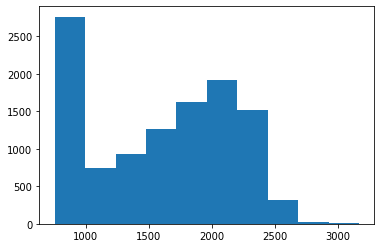

In [52]:
plt.hist(op['EngineRPM'])

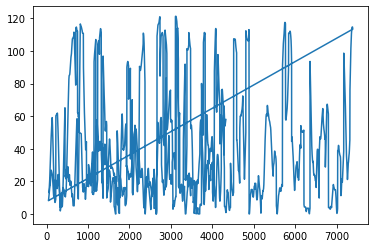

In [54]:
plt.plot(op['VehicleSpeedAverage'])